This notebook is for comparing the gap filling techniques visually

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch

In [13]:
# First import the model
from modules.MLPstuff import MLP
from modules.util import grab_data

In [31]:
# Load the data on which predictions and or gap filling are to be done
from columns import COLS_FEATURES
input, target, dim_in, dim_out = grab_data('data/data_merged_with_nans.csv', columns_data=COLS_FEATURES, return_dataset = False )

In [32]:
# Load the model
model = MLP(dim_in, dim_out, num_hidden_units=30, num_hidden_layers=4)
model.load_state_dict(torch.load('model_saves/mlp_30_4_RD.pth'))
model.eval()

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=9, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=30, bias=True)
    (7): ReLU()
    (8): Linear(in_features=30, out_features=30, bias=True)
    (9): ReLU()
    (10): Linear(in_features=30, out_features=2, bias=True)
  )
)

In [33]:
# Get an overview about NaNs per Row to remove input data nans
nan_counts = input.isnull().sum()
print("NaNs per column:")
print(nan_counts)

NaNs per column:
year                             0
month                            0
day                              0
30min                            0
location                         0
incomingShortwaveRadiation      30
soilHeatflux                   726
waterPressureDeficit          1218
windSpeed                      213
dtype: int64


In [34]:
# Identify the rows where the input data is missing and remove the faulty rows from both frames
valid_rows = input.dropna().index
input_orig = input
target_orig = target
input = input.loc[valid_rows]
target = target.loc[valid_rows]

In [35]:
# Now identify the rows where gaps are present in the H & LE which can be filled by our model & data
target_nan_indices = target[target.isnull().any(axis=1)].index
# Only use commplete data at the missing rows to predict
input = input.loc[target_nan_indices]
print(target_nan_indices)

Index([    0,     2,     4,     6,     8,    10,    12,    14,    16,    18,
       ...
       29060, 29061, 29062, 29064, 29070, 29074, 29076, 29077, 29086, 29087],
      dtype='int64', length=15378)


In [36]:
# transform input into torch.tensor and make predictions
input_tensor = torch.tensor(input.values, dtype=torch.float32)

with torch.no_grad():
    pred = model(input_tensor).numpy() #  Transform back to numpy 
# create dataframe of predictions with target rows and the indices of the missing values
pred = pd.DataFrame(pred, columns=target.columns, index=target_nan_indices)

pred.head()

,H_orig,LE_orig
0,-28.750574,13.750820
2,-28.523863,13.301523
4,-28.247978,13.139880
6,-28.046093,13.068932
8,-27.897934,12.853625


In [37]:
# Merge the predicted results into the target dataframe
for col in target.columns:
    target.loc[target_nan_indices, col] = pred.loc[target_nan_indices, col]

Text(0.5, 1.0, 'LE')

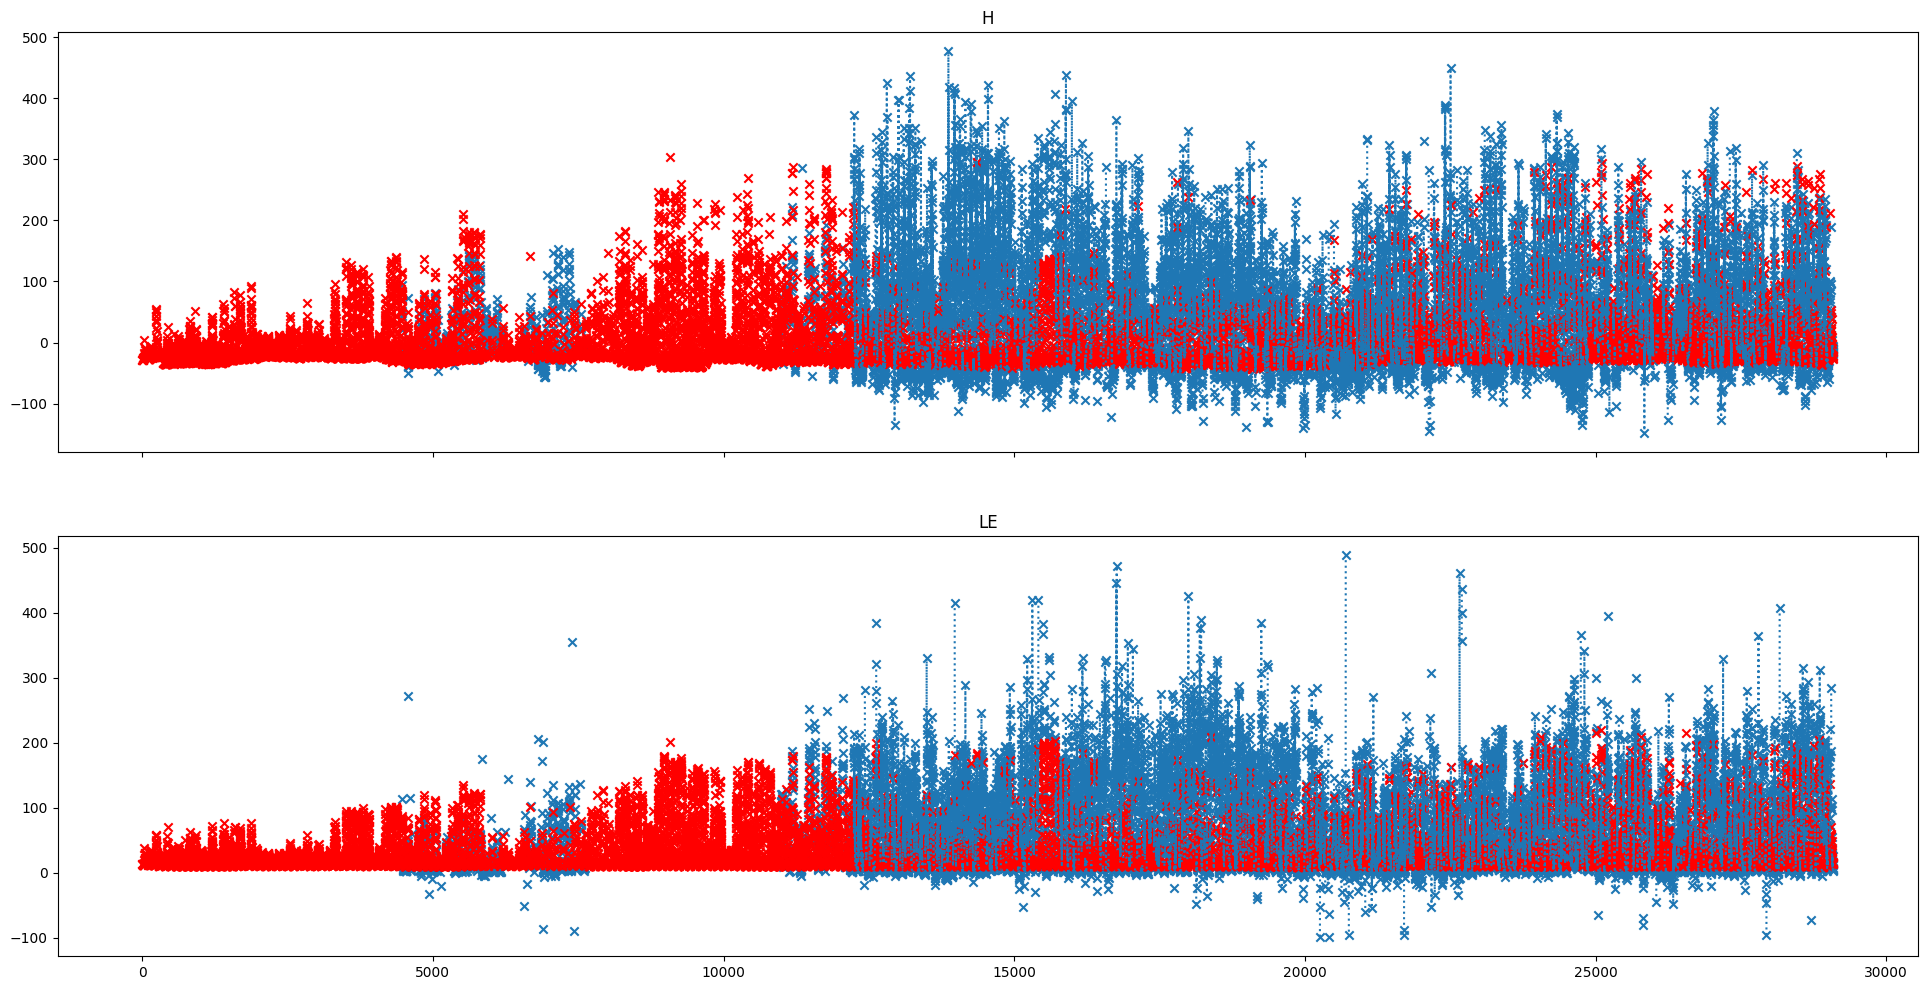

In [48]:
# Create plots of the filled frame

time = np.arange(len(target_orig))

fig, ax = plt.subplots(2,1, sharex=True, figsize=(24,12))

ax[0].scatter(time, target_orig['H_orig'].to_numpy(), marker='x')
ax[0].plot(time, target_orig['H_orig'].to_numpy(), linestyle='dotted' )
ax[0].scatter(target_nan_indices.to_numpy(), target['H_orig'].loc[target_nan_indices].to_numpy(), color='red', marker='x')
ax[0].set_title('H')

ax[1].scatter(time, target_orig['LE_orig'].to_numpy(), marker='x')
ax[1].plot(time, target_orig['LE_orig'].to_numpy(), linestyle='dotted' )
ax[1].scatter(target_nan_indices.to_numpy(), target['LE_orig'].loc[target_nan_indices].to_numpy(), color='red', marker='x')
ax[1].set_title('LE')

ValueError: x and y must be the same size

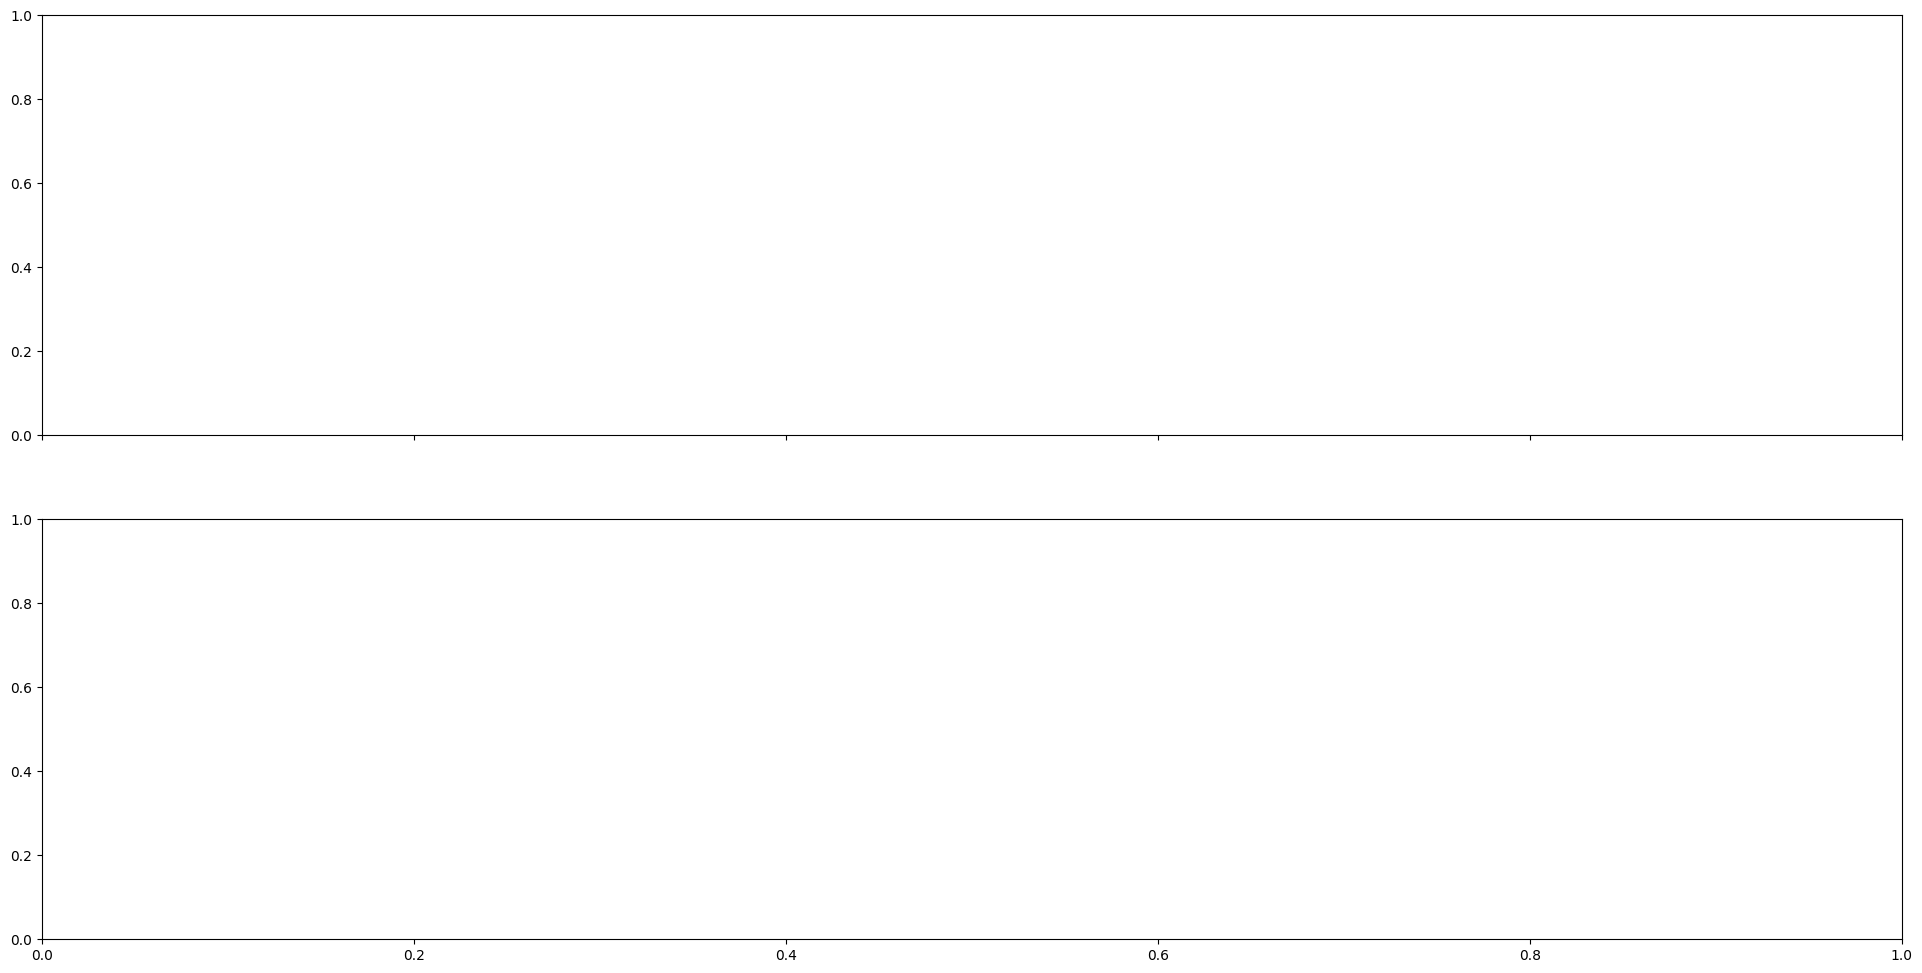

In [49]:
slice = [14000, 14048]

time = np.arange(len(target_orig))[slice[0]:slice[1]]

fig, ax = plt.subplots(2,1, sharex=True, figsize=(24,12))

ax[0].scatter(time[slice[0]:slice[1]], target_orig['H_orig'].to_numpy()[slice[0]:slice[1]], marker='x')
ax[0].plot(time[slice[0]:slice[1]], target_orig['H_orig'].to_numpy()[slice[0]:slice[1]], linestyle='dotted' )
ax[0].scatter(target_nan_indices.to_numpy(), target['H_orig'].loc[target_nan_indices].to_numpy(), color='red', marker='x')
ax[0].set_title('H')

ax[1].scatter(time[slice[0]:slice[1]], target_orig['LE_orig'].to_numpy()[slice[0]:slice[1]], marker='x')
ax[1].plot(time[slice[0]:slice[1]], target_orig['LE_orig'].to_numpy()[slice[0]:slice[1]], linestyle='dotted' )
ax[1].scatter(target_nan_indices.to_numpy(), target['LE_orig'].loc[target_nan_indices].to_numpy(), color='red', marker='x')
ax[1].set_title('LE')